In [1]:
# Run this cell first (shit+enter) to import all packages

from numpy import array, matrix, meshgrid, invert, ones,\
hstack, vstack, dot, linspace, sin, diag, abs, arange,\
cos, exp, identity
import numpy as np
from numpy.linalg import inv
from numpy.ma import masked_where
from matplotlib.pyplot import plot, fill_between

%matplotlib inline

# Gaussian Process Regression Demonstration

## About

This notebook is supplementary material for the lecture ["Maschinelles Lernen 2" at the Karlsruhe Insitute of  Technology](https://his.anthropomatik.kit.edu/28_327.php). It is intended to give the class' participants a feeling for the discussed algorithm and a brief introduction to numerical computation with python and [jupyter](http://jupyter.org). You are invited to modify the code but please do not share it outside the scope of the lecture.
To install it on windows, it is recommended to use the [anaconda distribution](https://docs.continuum.io/anaconda/install). Please inform us if you encounter problems with this notebook.

&copy; 2017, Stefan Ulbrich, Forschungszentrum Informatik, All rights reserved.

## Kernel functions

The kernel functions in this notebook use a [python decorator](http://wiki.python.org/moin/PythonDecorators/) that transforms the *first two* arguments into matrices which yield all combinations of the input vectors when compared element-wise (cf. Cartesian product). Note that this works only for vectors and not for matrices (see [this thread](http://stackoverflow.com/questions/1827489/numpy-meshgrid-in-3d) to handle higher dimensions).

Example:
$$ k\left((x_1,x_2)^T,(y_1,y_2)^T\right) \rightarrow \begin{pmatrix} k(x_1,y_1) & k(x_1,y_2) \\ k(x_2,y_1) & k(x_2,y_2) \end{pmatrix} $$


In [26]:
# Press shift+enter to execute this cell 
# and add the kernel functions

def kernel_function(f):
    def decorator(x,y,*args, **kwargs):
        xx,yy = meshgrid(x,y)
        val = f(xx,yy, *args, **kwargs)
        return matrix(val)
    return decorator

class kernels(object):
    @kernel_function
    def periodic(x,y):
        return np.exp(np.cos((x-y)))

    @kernel_function
    def squared_exponential(x,y):
        return np.exp(-((x-y)**2)/2)
    
    @kernel_function
    def exponential(x,y):
        return np.exp(-((x-y))/0.5)
    
    @kernel_function
    def symmetric(x,y):
        return np.exp(-((abs(x)-abs(y))**2)/3)
    
    @kernel_function
    def squared_exponential_param(x,y,signal_variance=1.0,
                                  length_scale=0.1):
        return signal_variance * \
                np.exp(-((x-y)**2)/length_scale)

## Regression Examples

### Squared Exponential

#### Definition
Kernel function **(stationary)**: 

$$ k(d) = \exp\left(-\frac{d^2}{2}\right), \quad \text{ where }  d= \| x-y \| $$

#### Evaluation

Remind that the evaluation of a GPR is based on the following formulas:

$$ \bar {\mathbf f_{L}} = \text{E}[\mathbf f_{\star}|X,X_{\star},\mathbf y] = K(X_{\star},X) \cdot (K(X,X)+\sigma^2I)^{-1} \cdot \mathbf f $$

$$ \text{cov} (\mathbf f_{\star})  = K(X_{\star},X_{\star}) - K(X_{\star},X) \cdot (K(X,X)+\sigma^2I)^{-1}\cdot K(X,X_{\star}) $$


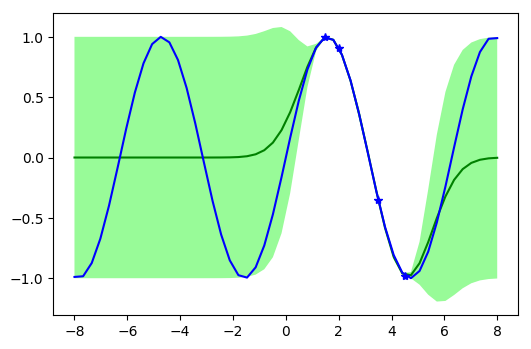

In [49]:
latent = lambda x: sin(x) # the latent function

# input values of the training instances
X = array([1.5,2,3.5,4.5]) 


## Uncomment the following two lines to see an example 
## showing that it is often necessary to determine the 
## hyperparameters of akernel:

# latent = lambda x: exp(-((x)**2)/0.5)
# X = array([-1,-0.25,0,0.25])


Y = latent(X)  # Compute the function values at 

# for plotting, evaluate the GP at many x-values
x = linspace(-8,8,50) 

kernel = kernels.squared_exponential 

cov_X = kernel(X,X) + identity(X.size)*0.0
cov_Xx = kernel(x,X)
cov_x = kernel(x,x)

mean = cov_Xx.T * inv(cov_X) * Y.reshape(-1,1)
var = cov_x  - cov_Xx.T * inv(cov_X) * cov_Xx


upper = mean+var.diagonal().T
lower = mean-var.diagonal().T


plot(x,mean,'-g')
fill_between(x, upper.A.flatten(), lower.A.flatten(), 
             lw=0, facecolor='palegreen', interpolate=True)
plot(X,Y,'*b')
plot(x,latent(x),'-b')




### A symmetric kernel

Kernel function **(non-stationary)**: 

$$k(x,y) = \exp\left(-\frac{(|x|-|y|)^2}{2}\right) $$

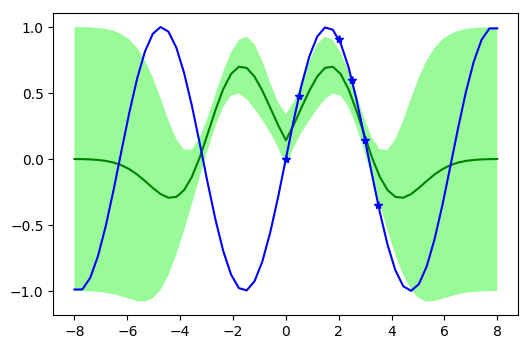

In [53]:
latent = lambda x: sin(x)

X = array([1.5,2,2.5]) 
X = array([0,0.5,2,2.5,3,3.5]) # Better results
#X = array([-0.5,0,0.5,2,2.5,3,3.5]) # We need regulazation (A non-zero noise term)

Y = latent(X)  
x = linspace(-8,8,55) 

kernel = kernels.symmetric

cov_X = kernel(X,X) + identity(X.size)*0.4
cov_Xx = kernel(x,X)
cov_x = kernel(x,x)

mean = cov_Xx.T * inv(cov_X) * Y.reshape(-1,1)
var = cov_x  - cov_Xx.T * inv(cov_X) * cov_Xx


upper = mean+var.diagonal().T
lower = mean-var.diagonal().T


plot(x,mean,'-g')
fill_between(x, upper.A.flatten(), lower.A.flatten(), 
             lw=0, facecolor='palegreen', interpolate=True)
plot(X,Y,'*b')
plot(x,latent(x),'-b')




### Periodic kernel

Kernel function **(stationary)**: 

$$ k(d) = \exp(\cos(d)$$

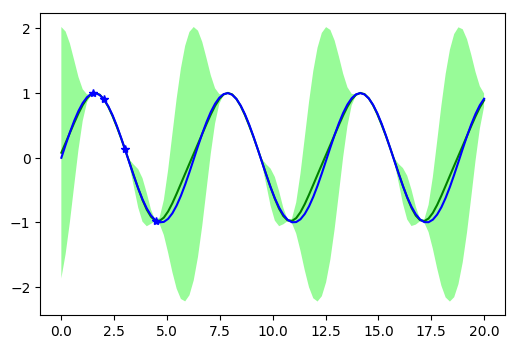

In [54]:
latent = lambda x: sin(x)

## Experiment with higher frequencies!
# latent = lambda x: sin(x*2)

X = array([1.5,2,3,4.5])
Y = latent(X)  
x = linspace(0,20,100) 

kernel = kernels.periodic

cov_X = kernel(X,X) + identity(X.size)*0.0
cov_Xx = kernel(x,X)
cov_x = kernel(x,x)

mean = cov_Xx.T * inv(cov_X) * Y.reshape(-1,1)
var = cov_x  - cov_Xx.T * inv(cov_X) * cov_Xx


upper = mean+var.diagonal().T
lower = mean-var.diagonal().T


plot(x,mean,'-g')
fill_between(x, upper.A.flatten(), lower.A.flatten(), 
             lw=0, facecolor='palegreen', interpolate=True)
plot(X,Y,'*b')
plot(x,latent(x),'-b')




### Paramterized Squared Exponential

Kernel **(stationary)**:
$$ k(d) = \sigma_f^2 \cdot \exp(\frac{-d^2}{2\cdot l^2}) + \sigma_n^2 \delta(d) $$

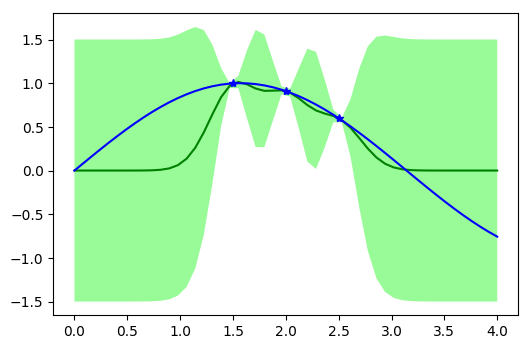

In [58]:
latent = lambda x: sin(x)

X = array([1.5,2,2.5])
Y = latent(X)  
x = linspace(0,4,50) 


# setup the hyperparameters

signal_variance=1.5
length_scale=0.1
noise_variance=0


# Shortcut (no need to modify successing code)
kernel = lambda a,b: \
    kernels.squared_exponential_param(a,b, signal_variance, 
                                      length_scale)


cov_X = kernel(X,X) + identity(X.size)*noise_variance
cov_Xx = kernel(x,X)
cov_x = kernel(x,x)

mean = cov_Xx.T * inv(cov_X) * Y.reshape(-1,1)
var = cov_x  - cov_Xx.T * inv(cov_X) * cov_Xx


upper = mean+var.diagonal().T
lower = mean-var.diagonal().T



plot(x,mean,'-g')
fill_between(x, upper.A.flatten(), lower.A.flatten(), 
             lw=0, facecolor='palegreen', interpolate=True)
plot(X,Y,'*b')
plot(x,latent(x),'-b')




### Polynomial Kernel

Kernel **(?)**:
$$ k(x,y) = \phi(x)^t\cdot\phi(y) + \sigma_n^2 \delta(d) $$

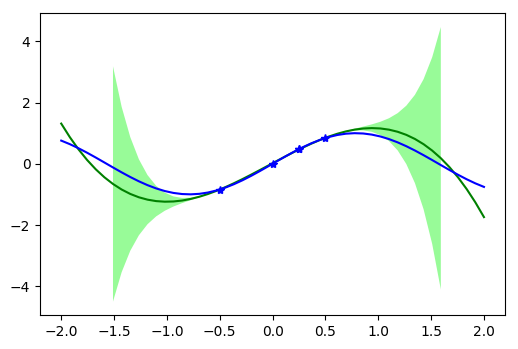

In [48]:
@kernel_function
def polynomial(x,y,deg):
    """
    Polynomial kernel (inefficient as it uses for-loops)
    """
    result = ones(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            phi_x = x[i,j]**arange(deg+1)
            phi_y = y[i,j]**arange(deg+1)
            result[i,j] = dot(phi_x,phi_y) 
                    
    return result

latent = lambda x:sin(x*2)

X = array([-0.5, 0.25, 0., 0.25, 0.5])
Y = latent(X)  
x = linspace(-2,2,50) 

# Experiment with the noise value! 
# See what happen for noise=0 (numerical instability).
noise=0.001

kernel = lambda a,b: polynomial(a,b, 3)


cov_X = kernel(X,X) + + identity(X.size)*noise 
cov_Xx = kernel(x,X)
cov_x = kernel(x,x)

mean = cov_Xx.T * inv(cov_X) * Y.reshape(-1,1)
var = cov_x  - cov_Xx.T * inv(cov_X) * cov_Xx

plot(x,mean,'-g')
plot(X,Y,'*b')
plot(x,latent(x),'-b')


# Note: Here we cut of values >/< +/- 5 as 
# the variance increases quickly!

upper = (mean+var.diagonal().T).A.flatten()
lower = (mean-var.diagonal().T).A.flatten()

upper = masked_where(upper > 5.0, upper)
lower = masked_where(lower < -5.0, lower)

fill_between(x, upper, lower, lw=0, 
             facecolor='palegreen', interpolate=True)


